# 5SSG2060 Practical Week 8 :  Spatial Weights & Spatial Autocorrelation
<a href="#This Week's Overview">This Week's Overview</a>

<a href="#Learn Outcomes">Learn Outcomes</a> 

<a href='#Get prepared'>Get prepared</a>
  - <a href='#Data'>Data<a/>

<a href='#Spatial Weights'>Spatial Weights</a>
  - <a href='#Contiguity Based Weights'>Contiguity Based Weights<a/>
  - <a href='#Distance Based Weights'>Distance Based Weights</a>
  - <a href='#Kernel Weights'>Kernel Weights<a/>

<a href='#Spatial Lag'>Spatial Lag</a>
  - <a href='#Spatial Similarity'>Spatial Similarity<a/>
  - <a href='#Moran Plot'>Moran Plot<a/>
    
<a href='#Spatial Autocorrelation'>Spatial Autocorrelation</a>
  - <a href='#Global spatial autocorrelation'>Global spatial autocorrelation<a/>
  - <a href='#Local spatial autocorrelation'>Local spatial autocorrelation<a/>

- <a href='#Task 1'>Task 1<a/>
- <a href='#Task 2'>Task 2<a/>
- <a href='#Task 3'>Task 3<a/>
- <a href='#Task 4 (Optional)'>Task 4 (Optional)<a/>
- <a href='#Task 5'>Task 5<a/>
- <a href='#Task 6'>Task 6<a/>
- <a href='#Task 7'>Task 7<a/>
- <a href='#Task 8'>Task 8<a/>
- <a href='#Task 9'>Task 9<a/>
- <a href='#Task 10'>Task 10<a/>

# <a id="This Week's Overview">This Week's Overview</a>
This practical will make you more confident with your understanding of Spatial Weights by 3 main types: the widely used contiguity based weights, the distance based weights and kernel weights. You will be provided the functions from `PySAL` and `Libpysal` to explore the features for corresponding functions, and conduct further comparisons among the results. Upon the interpretation of spatial weights, concepts of `Spatial Lag` and `Global Spatial Autocorrelation` will be presented with variables on london housing, as well as detailed explanations on their processes and corresponding visualizations.

Since Moran's I value can only tells us the existence of global spatial autocorrelation, but incapable to help identifying where the clusters are; in another word, if we want explore further on the spatial instability incurred by particular areas' departuring from the general pattern, we need to explore some local measures to obtain further insight by using `Local Indicators of Spatial Association (LISAs)` in `PySAL` to classify observations in our dataset into four groups, each of which are based on Moran plot and called "quadrants".
- high values surrounded by high values (HH), in what we call `hot spots`.
- low values nearby other low values (LL), in what we call `cold spots`.
- high values among low values (HL), in what we call `spatial outliers`.
- low values among high values (LH), in what we call `spatial outliers`.

# <a id="Learn Outcomes">Learn Outcomes</a>
You will practice your understanding on the concepts delivered in lecture, which are:
- Spatial weights (Contiguity based, Distance based, kernel weights)
- Spatial Lag
- Spatial Autocorrelation (Global & Local)

You will further explore the functions provided in `PySAL` and `Libpysal`.
# <a id="Get prepared">Get prepared</a>

In [1]:
import sys
import os
import urllib
import zipfile
import geopandas as gpd
import seaborn as sns
import libpysal as lps
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pysal.contrib.viz import mapping as viz
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

## <a id='Data'>Data<a/>
For this practical, we are going to use 3 datasets: besides of the **airbnb data** we've used in previous practicals, the **shapefile data for London boroughs** will be utilized as geographical units, and we add a new dataset **Housing in London 2018 dataset (for 2016-17 data)**[Tackling London's housing crisis](https://www.london.gov.uk/what-we-do/housing-and-land/tackling-londons-housing-crisis)(If you want more housing price data in 2014, 2015 and 2017, it is also available from London Datastore).

So please copy your airbnb listings data into this week's "data" folder, download the other two datasets from CUSP London Github as usual.

In [2]:
# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/housing_in_london.csv?raw=true'
path = os.path.join("data","housing_in_london.csv")

# Download
r    = urllib.request.urlretrieve(url, path)

In [3]:
# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/borough.zip?raw=true'
path = os.path.join("data","borough.zip")

# Download
r    = urllib.request.urlretrieve(url, path)
# Unzip it into the data folder
z    = zipfile.ZipFile(path)
m    = z.extractall("data")

In [4]:
# read the airbnb listings data 
df0=pd.read_csv('data/airbnb_listings.csv')
# only keep columns we are interested in
variables=['price', 'number_of_reviews']
# group the number of airbnbs by "neighbourhood", which is actually borough
df1_new = df0.groupby(['neighbourhood'])[variables].mean().reset_index()
df1_new.head()

,neighbourhood,price,number_of_reviews
0,Barking and Dagenham,50.992188,4.726562
1,Barnet,72.339479,6.131236
2,Bexley,48.531532,5.675676
3,Brent,81.541949,7.907307
4,Bromley,62.375000,6.350610


In this case, the airbnbs have been grouped by borough, so the "price" and "number_of_reviews" in each borough will be presented with the average value. However, we've missed a very import element in this way, the count of airbnbs in each borough. So let's get a new column for count of airbnbs as following:

In [5]:
# count airbnb in each borough
df1_count=pd.DataFrame(df0['neighbourhood'].value_counts().astype(int)).reset_index()
df1_count.columns=['Borough', 'Number of Airbnbs']
df1_count.head()

,Borough,Number of Airbnbs
0,Tower Hamlets,5072
1,Westminster,4703
2,Hackney,4462
3,Camden,3512
4,Kensington and Chelsea,3298


We want to append this new column to df1_new dataframe to build up an updated df1 for further use.

In [6]:
df1=df1_count.join(df1_new.set_index(['neighbourhood']), on=['Borough'], how='left')
df1.head()

,Borough,Number of Airbnbs,price,number_of_reviews
0,Tower Hamlets,5072,77.049487,11.739353
1,Westminster,4703,150.955773,15.049968
2,Hackney,4462,85.190049,9.586508
3,Camden,3512,121.052961,14.628986
4,Kensington and Chelsea,3298,156.711643,12.397817


Dataset 1 is ready, and now let's have a look of dataset 2.

In [7]:
# read the london housing data and have a look
df2=pd.read_csv('data/housing_in_london.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 13 columns):
Borough                   33 non-null object
Sector                    33 non-null object
Population                33 non-null int64
Households                33 non-null int64
Dwellings                 33 non-null int64
person_dwelling           33 non-null float64
house_stock_growth        32 non-null float64
house_stock_affordable    33 non-null int64
net_homes                 33 non-null int64
private_rent              33 non-null int64
house_price               33 non-null int64
earnings                  32 non-null float64
ratio_price_earning       33 non-null int64
dtypes: float64(3), int64(8), object(2)
memory usage: 3.4+ KB


The column "Borough" in df2 is actually the same with "Borough" in df1, so we can try to join these two datasets by the shared column.

In [8]:
# Join these two datasets
db=df2.join(df1.set_index(['Borough']), on=['Borough'], how='left')
db.shape

(33, 16)

As you've been provided the data for London boroughs, we can further get the spatial dataset merged with this newly generated asaptial dataset, and save it as shapefile just in our usual way. This spatial data will be further used next week to realize spatial regression.

In [9]:
borough=gpd.read_file('data/borough/boroughs.shp')
borough=borough.rename(columns={'NAME': 'Borough'})
borough_db = borough[['geometry', 'Borough']].merge(db, on='Borough')
# save this newly created file into .shp file
borough_db.to_file(driver='ESRI Shapefile', filename='data/borough_airbnb_housing.shp')
borough_db.head()

,geometry,Borough,Sector,Population,Households,Dwellings,person_dwelling,house_stock_growth,house_stock_affordable,net_homes,private_rent,house_price,earnings,ratio_price_earning,Number of Airbnbs,price,number_of_reviews
0,POLYGON ((-0.3306936415070752 51.3290679022793...,Kingston upon Thames,Outer,173703,70175,66410,2.6,0.02,7420,273,1300,484965,37865.0,16,302,76.486755,6.652318
1,POLYGON ((-0.0640409250229735 51.3186954126904...,Croydon,Outer,383301,156027,152520,2.5,0.05,26510,2835,1100,372024,33821.0,11,470,56.668085,6.176596
2,POLYGON ((0.01210989689387686 51.2996573924981...,Bromley,Outer,327580,137972,136860,2.4,0.02,18950,858,1150,445387,40490.0,15,328,62.375000,6.350610
3,POLYGON ((-0.2445796318688628 51.4887559775884...,Hounslow,Outer,268270,104711,98790,2.7,0.04,26650,557,1300,407680,31764.0,11,602,88.089701,11.740864
4,POLYGON ((-0.4118469484208172 51.5341363235970...,Ealing,Outer,344802,130659,130530,2.6,0.03,23950,845,1400,481834,32991.0,16,855,90.856140,11.069006


The labels for columns seem to be alright without any changes. However, after we save the data into shapefile, the columns labels actually had already changed due to ruled number limit of 10 letters. You may double check the variables' name by reading data into geodataframe as below:

In [10]:
gdf=gpd.read_file('data/borough_airbnb_housing.shp')
gdf.head()

,Borough,Sector,Population,Households,Dwellings,person_dwe,house_stoc,house_st_1,net_homes,private_re,house_pric,earnings,ratio_pric,Number of,price,number_of_,geometry
0,Kingston upon Thames,Outer,173703,70175,66410,2.6,0.02,7420,273,1300,484965,37865.0,16,302,76.486755,6.652318,POLYGON ((-0.3306936415070752 51.3290679022793...
1,Croydon,Outer,383301,156027,152520,2.5,0.05,26510,2835,1100,372024,33821.0,11,470,56.668085,6.176596,POLYGON ((-0.0640409250229735 51.3186954126904...
2,Bromley,Outer,327580,137972,136860,2.4,0.02,18950,858,1150,445387,40490.0,15,328,62.375000,6.350610,POLYGON ((0.01210989689387686 51.2996573924981...
3,Hounslow,Outer,268270,104711,98790,2.7,0.04,26650,557,1300,407680,31764.0,11,602,88.089701,11.740864,POLYGON ((-0.2445796318688628 51.4887559775884...
4,Ealing,Outer,344802,130659,130530,2.6,0.03,23950,845,1400,481834,32991.0,16,855,90.856140,11.069006,POLYGON ((-0.4118469484208172 51.5341363235970...


Since the labels changed as expected (10 letters limit, remember?), we need to rename them back into some human language again.

In [11]:
#change column names here. 
cnames = {'Borough' : 'borough', 
          'Sector' : 'sector', 
          'Population': 'population', 
          'Households' : 'households', 
          'Dwellings' : 'dwellings', 
          'person_dwe' : 'per_dwell', 
          'house_stoc' : 'house_growth', 
          'house_st_1' : 'house_stock',
          'net_homes' : 'net_home', 
          'private_re': 'private_rent_price',
          'house_pric': 'house_price',
          'ratio_pric': 'ratio_price_earn',
          'price': 'listing_price',
          'number_of_': 'reviews',
          'Number of': 'airbnb_amount',
          'geometry': 'geometry' 
         }
gdf.rename(columns=cnames, inplace=True)

### <a id='Task 1'>Task 1<a/>
If we want to get a rough idea about the distribution frequency of airbnbs across boroughs in London, we can plot a quantile map. So recall your memory to draw a simple quantile map for $variable$ 'airbnb_amount' and set up the $cmap$ value as 'coolwarm'.

**Hint**: scheme to be 'quantiles'.

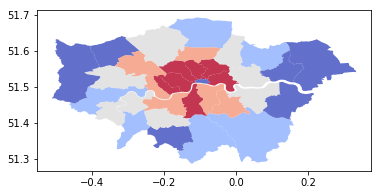

In [12]:
# your code here
gdf.plot(column='airbnb_amount', alpha=0.8, cmap='coolwarm', scheme='quantiles')

However, as we are going to calculate the spatial weights by distance today, we need to be more careful about **crs**; it means that we need to reset the crs to epsg 27700 again, but I am sure you are more familiar with the steps now.

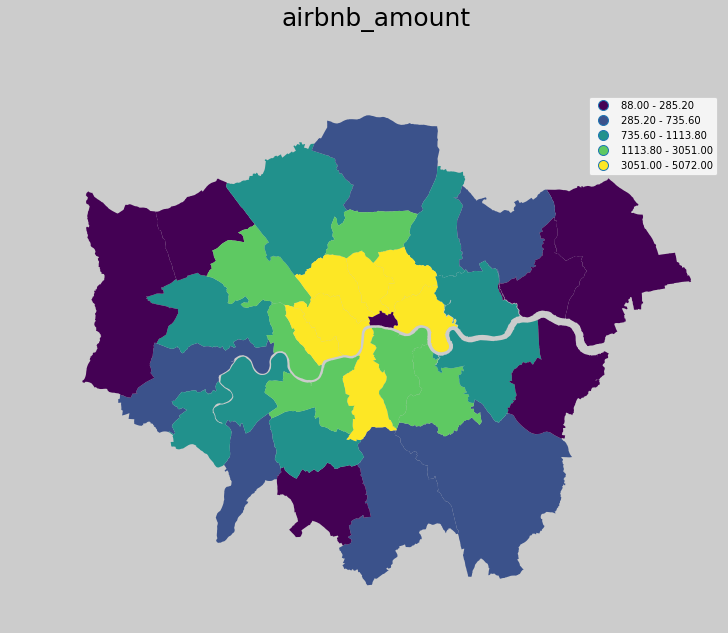

In [13]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,10))
# Plot Number of Airbnbs
# Quickly transform to OSGB CRS and plot 
gdf.to_crs(epsg=27700).plot(column='airbnb_amount', scheme='Quantiles', legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.8')
# set up the title
f.suptitle('airbnb_amount', size=25)

plt.show()

Similar maps but stretched, right? Once you are prepared, let's start our spatial calculation.
## <a id='Spatial Weights'>Spatial Weights</a>

Spatial weights are mathematical structures representing for spatial relationships, and are crucial components of spatial analysis. Generally it is a $nxn$ matrix measuring the potential spatial relationships between paired observations in a spatial dataset，which is on $n$ locations with varied geometries. The spatial relationships between these geometries can be based on criteria like:
- Contiguity Based Weights
- Distance Based Weights (both geospatial distance and general distance)
- Kernel Weights

In spatial weights matrix, the geographical space is encoded into numerical form for statistical practice.The elements in diagons $w_{ii}$ are set to zero while the rest cells $w_{ij}$ measure the potential interactions between each pair at location $i$ and $j$.

We are going to realize the function using `PySAL` to create, manipulate and analyze spatial weights matrices across different types in the following section. For further details see the Spatial Weights [API](https://pysal.readthedocs.io/en/latest/library/weights/index.html).

### <a id='Contiguity Based Weights'>Contiguity Based Weights</a>

Contiguity Weights can be built from dataframe with a geometry column or from  contiguity graph representation, e.g.shapefile. In this section, we will use contiguity to define neighboring observations: use `weights.Contiguity`module in `PySAL` to constructe and manipulate spatial weights matrices based on contiguity criteria; and to use `weights.Contiguity` in `libpysal` to further get the idea plotted out.

Three contiguity weights will be compared: **Queen**, **Rook** and **Bishop**.
#### Queen contiguity weight
This commonly used weight type build a queen contiguity matrix for our data, , reflecting the adjacency relationship whether a polygon shares an **edge** or a **vertex** with another polygon or not. A pair of boroughs to be considered neighbours under this $W$ will need to "touch" each other to some degree. As the weights are symmetric, if borough $A$ neighbors borough $B$, then both $w_{AB} = 1$ and $w_{BA} = 1$.

We will begin with the `GeoDataFrame` and pass it on to the queen contiguity weights builder in `PySAL` (`ps.weights.Queen.from_dataframe`). 

In [14]:
# Create the spatial weights matrix
w_queen = ps.weights.Queen.from_dataframe(gdf)
w_queen.n

33

In [15]:
print ('%.4f'%w_queen.pct_nonzero) # percentage of non zero queen weights

12.4885


In [16]:
w_queen.histogram # frequency of n neighbors 

[(2, 2), (3, 10), (4, 9), (5, 7), (6, 4), (7, 1)]

The index used in weights are the same with dataframe, so let's try to check which boroughs are neighbors of observation `City of London` with index `32`, and how much they are "weighted".

In [17]:
w_queen[32]

{24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0}

Can you get the name list for neighbours? For example, put the the target borough and its neighbours' indexes and names presented in one list:

In [18]:
# They are Westminster, Camden, Tower Hamlets, Islington and Hackney. 
target_borough = [32]
target_borough.extend(w_queen.neighbors[32])
gdf.loc[target_borough]

,borough,sector,population,households,dwellings,per_dwell,house_growth,house_stock,net_home,private_rent_price,house_price,earnings,ratio_price_earn,airbnb_amount,listing_price,reviews,geometry
32,City of London,Inner,7246,4276,6230,1.2,NaN,670,7,1950,755178,NaN,15,280,179.353571,14.250000,POLYGON ((-0.1115943708755045 51.5108085891082...
24,Westminster,Inner,241974,120623,121120,2.0,0.05,27400,1342,2265,1025871,43203.0,25,4703,150.955773,15.049968,POLYGON ((-0.1500228909502615 51.4855383161366...
25,Camden,Inner,249162,109515,101650,2.5,0.04,34460,1208,1820,821464,40115.0,20,3512,121.052961,14.628986,POLYGON ((-0.142435611055591 51.56917265544989...
26,Tower Hamlets,Inner,300943,125850,110790,2.7,0.09,43330,4827,1647,469550,37603.0,10,5072,77.049487,11.739353,POLYGON ((-0.07940004058495014 51.507896596564...
27,Islington,Inner,232055,105270,100760,2.3,0.06,41480,674,1712,657474,37982.0,16,3288,94.839416,12.615876,POLYGON ((-0.1384141656620681 51.5569118421580...
28,Hackney,Inner,273239,116109,106750,2.6,0.06,46150,1196,1603,567005,34507.0,16,4462,85.190049,9.586508,POLYGON ((-0.09768537311659123 51.573704606438...


Let us row-standardize it to make sure every row of the matrix sums up to one, and check the neighbours for City of London again.

In [19]:
# Row standardize the matrix
w_queen.transform = 'R'
w_queen[32]

{24: 0.2, 25: 0.2, 26: 0.2, 27: 0.2, 28: 0.2}

What you get this time? The weight given to each neighbour has changed from 1.0 to 0.25! Think of the reason, and the sum of their weights, it should be 1 after the row-standardizing.
We call `pysal.full` to get a full, dense matrix describing all of the pairwise relationships:

In [20]:
wqmatrix, ids = w_queen.full()
wqmatrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.2       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
n_neighbors = wqmatrix.sum(axis=1) # how many neighbors in each region 

In [22]:
n_neighbors[32]

1.0

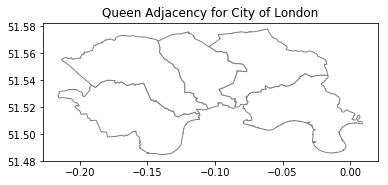

In [23]:
queen_neighs=w_queen.neighbors[32]
q=gdf.loc[queen_neighs].plot(edgecolor='grey', facecolor='w')
title=plt.title('Queen Adjacency for City of London')

The Queen contiguity weights is also available by calling `libpysal`, and it is more visiable of the contiguity when plotting.

In [24]:
w_queen_1 = lps.weights.Queen.from_dataframe(gdf)
type(w_queen_1)

libpysal.weights.contiguity.Queen

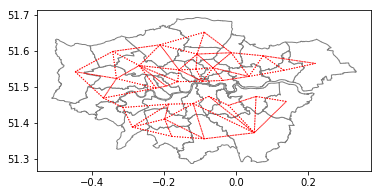

In [25]:
ax = gdf.plot(edgecolor='grey', facecolor='w')
f,ax = w_queen_1.plot(gdf, ax=ax, 
                   edge_kws=dict(color='r', linestyle=':', linewidth=1),
                   node_kws=dict(marker=''))

Think of the rationale for using queen weights from libpysal, rather than that from pysal, for plotting. How if you change it to the latter? What you may get and why?

#### Rook contiguity weights

Rook weights define neighbors as those sharing an edge on their respective borders. At finer scales, the rook neighbors of an observation may be different from the queen neighbors, depending on the configuration of both targeted observation and 'neighbors'. This time we use `.from_shapefile` function to get the rook neighbors.

In [37]:
w_rook = ps.rook_from_shapefile('data/borough_airbnb_housing.shp')

### <a id='Task 2'>Task 2<a/>
Since we get a new spatial weight matrix by using Rook rather than Queen, we need do similar work to get the corresponding values as below:

In [38]:
w_rook.n

33

In [27]:
w_rook.pct_nonzero  # Percentage of nonzero neighbor counts

12.488521579430671

In [28]:
w_rook.histogram

[(2, 2), (3, 10), (4, 9), (5, 7), (6, 4), (7, 1)]

In [29]:
w_rook.neighbors[32] # get the indices for neighbors of City of London

[24, 25, 26, 27, 28]

In [30]:
gdf['borough'][[24, 25, 26, 27, 28]]

24      Westminster
25           Camden
26    Tower Hamlets
27        Islington
28          Hackney
Name: borough, dtype: object

So City of London has 5 rook neighbors: Westminster, Camden, Tower Hamlets, Islington and Hackney; the same as queen neighbors at borough level.

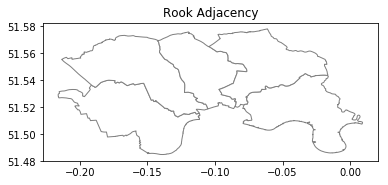

In [31]:
rook_neighs=w_rook.neighbors[32]
r=gdf.loc[rook_neighs].plot(edgecolor='grey', facecolor='w')
title=plt.title('Rook Adjacency')

### <a id='Task 3'>Task 3<a/>
Similarly, we can try to call `libpysal` to get the spatial weights visualized.

In [32]:
w_rook_1 = lps.weights.Rook.from_shapefile('data/borough_airbnb_housing.shp')
type(w_rook_1)

libpysal.weights.contiguity.Rook

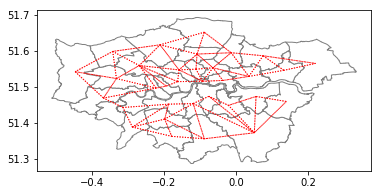

In [33]:
ax = gdf.plot(edgecolor='grey', facecolor='w')
f,ax = w_rook_1.plot(gdf, ax=ax, 
                   edge_kws=dict(color='r', linestyle=':', linewidth=1),
                   node_kws=dict(marker=''))

To prove our test on the similarity of results between Queen weight and Rook weight:

In [34]:
(w_queen.pct_nonzero == w_rook.pct_nonzero) == (w_queen.n == w_rook.n)

True

#### Bishop contiguity weights

Bishop weighting only consider polygons as neighbors when they share vertexes. It is not directly available from `PySAL`, but we can construct it by using `w_difference` function.

In [35]:
w_bishop = ps.w_difference(w_queen, w_rook, constrained=False, silent_island_warning=True)
w_bishop.histogram

[(0, 33)]

From the histogram result, we can tell for this dataset: boroughs in London has no bishop neighbors, which means there is no borough only share vertexes without sharing any edges. But if for other cases they do have, we can use this function or simply call the `islands` to check.

In [36]:
w_bishop.islands

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

### <a id='Task 4 (Optional)'>Task 4 (Optional)<a/>
Get both Rook weights and Queen weights plotted. 

array([-0.6,  0.4, 51.2, 51.7])

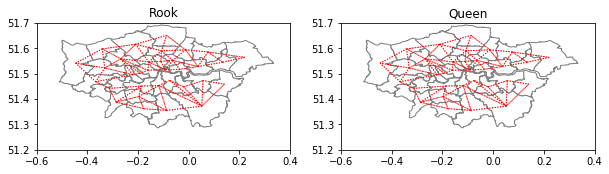

In [39]:
# plot them your code here
f,ax = plt.subplots(1,2,figsize=(10, 6), subplot_kw=dict(aspect='equal'))
gdf.plot(edgecolor='grey', facecolor='w', ax=ax[0])
w_rook_1.plot(gdf, ax=ax[0], 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax[0].set_title('Rook')
ax[0].axis(np.asarray([-0.6, 0.4, 51.2, 51.7]))

gdf.plot(edgecolor='grey', facecolor='w', ax=ax[1])

w_queen_1.plot(gdf, ax=ax[1], 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax[1].set_title('Queen')
ax[1].axis(np.asarray([-0.6, 0.4, 51.2, 51.7]))

###  <a id='Distance Based Weights'>Distance Based Weights</a>
Besides of contiguity defined neighbors, we can also use distance to define neighbors in a more common way. We can use [`weights.Distance` module](https://pysal.readthedocs.io/en/latest/library/weights/Distance.html) in `PySAL`. However, if you recap on what we've done on Week 4 and Week 5, the measurement of distance should be careful about crs. So we need ensure the shapefile used has been projected in the right way.
#### k-nearest neighbor weights
We use k-nearest neighbor criterion to define neighbors for target observation. For example, we set $k=4$ for a trial.

In [40]:
w_knn = ps.weights.KNN.from_dataframe(gdf, k=4)

In [41]:
w_knn.histogram

[(4, 33)]

In [42]:
w_knn.s0

132.0

In [43]:
# could you check the definition of s0 by your own code?
help(ps.W.s0)

Help on property:

    s0 is defined as
    
    .. math::
    
           s0=\sum_i \sum_j w_{i,j}



We could also use this function to call all the neighbors' list:

In [44]:
listnei = w_knn.reweight(p=1, inplace=False)
listnei.neighbors

{0: [19, 20, 18, 3],
 1: [18, 10, 11, 2],
 2: [13, 12, 1, 30],
 3: [19, 4, 6, 7],
 4: [7, 3, 19, 8],
 5: [31, 17, 14, 30],
 6: [4, 3, 7, 8],
 7: [4, 8, 9, 3],
 8: [4, 22, 7, 9],
 9: [8, 25, 29, 22],
 10: [11, 21, 32, 12],
 11: [32, 10, 12, 26],
 12: [11, 26, 13, 10],
 13: [30, 14, 12, 2],
 14: [31, 13, 12, 30],
 15: [29, 28, 27, 16],
 16: [28, 17, 29, 26],
 17: [30, 16, 31, 13],
 18: [20, 1, 21, 0],
 19: [0, 3, 4, 21],
 20: [21, 18, 23, 22],
 21: [20, 23, 10, 22],
 22: [23, 24, 21, 8],
 23: [22, 24, 21, 25],
 24: [25, 23, 32, 22],
 25: [24, 27, 23, 29],
 26: [32, 28, 11, 30],
 27: [29, 25, 28, 32],
 28: [27, 26, 32, 29],
 29: [27, 15, 28, 32],
 30: [13, 26, 17, 31],
 31: [14, 17, 5, 30],
 32: [27, 26, 11, 28]}

In [45]:
from libpysal.weights import KNN
w_knn_1 = KNN.from_dataframe(gdf, k=4)

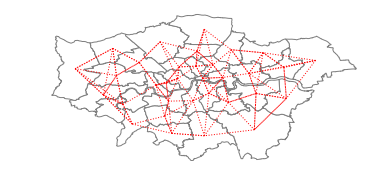

In [46]:
ax = gdf.plot(edgecolor='grey', facecolor='w')
f,ax = w_knn_1.plot(gdf, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

The $k$ value could be adjusted when we want to change the weights by calling `reweight`, this will help us to change the weight object without re-constructing the KDTree when computing the nearest neighbors queries. For example, we want to change the $k$ value into 5: 

### <a id='Task 5'>Task 5<a/>
Let's still take City of London as an example again, and compare the outputs for K=5 with k=4.

In [47]:
# get the w_knn neighbors list for City of London
# hint: simply call its index
w_knn.neighbors[32]

[27, 11, 28, 26]

In [48]:
# use the reweight function to reset the k as 5
w_knn_r = w_knn.reweight(k=5, inplace=False)
# new list of neighbors for City of London
w_knn_r.neighbors[32]

[27, 11, 28, 26, 10]

In [49]:
# new s0 value
w_knn_r.s0

165.0

In [50]:
set(w_knn_r.neighbors[32]) == set([27, 11, 28, 26, 10])

True

In [51]:
w_knn_r.weights[32]

[1.0, 1.0, 1.0, 1.0, 1.0]

#### Distance Band Weights
You may observed already that using $knn$ weights, we will get all target observations with same number of neighbors. If we use  distance bands or thresholds to define neighbors, to find those falling into the defined threshold distance, then the neighbors vary. The distance band weights could be generated from array, dataframe, shapefile, specified values, etc. We are here to try get an example from dataframe:

In [52]:
w_thresh = ps.weights.DistanceBand.from_dataframe(gdf, threshold=0.1, geom_col='geometry')
w_thresh.neighbors

{0: [19, 20],
 1: [18],
 2: [],
 3: [4, 19],
 4: [3, 7, 8, 19],
 5: [31],
 6: [],
 7: [4, 8],
 8: [4, 7, 9, 22, 23],
 9: [8, 25],
 10: [11, 12, 20, 21, 23, 24, 27, 32],
 11: [10, 12, 24, 26, 27, 28, 32],
 12: [10, 11, 13, 26, 30, 32],
 13: [12, 14, 30],
 14: [13, 31],
 15: [16, 29],
 16: [15, 17, 26, 28, 29, 30],
 17: [16, 30, 31],
 18: [1, 20, 21],
 19: [0, 3, 4],
 20: [0, 10, 18, 21, 22, 23],
 21: [10, 18, 20, 22, 23, 24, 25],
 22: [8, 20, 21, 23, 24, 25],
 23: [8, 10, 20, 21, 22, 24, 25, 27],
 24: [10, 11, 21, 22, 23, 25, 27, 29, 32],
 25: [9, 21, 22, 23, 24, 27, 28, 29, 32],
 26: [11, 12, 16, 27, 28, 30, 32],
 27: [10, 11, 23, 24, 25, 26, 28, 29, 32],
 28: [11, 16, 25, 26, 27, 29, 32],
 29: [15, 16, 24, 25, 27, 28, 32],
 30: [12, 13, 16, 17, 26, 31],
 31: [5, 14, 17, 30],
 32: [10, 11, 12, 24, 25, 26, 27, 28, 29]}

In [53]:
w_thresh.weights[32]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### <a id='Kernel Weights'>Kernel Weights<a/>

We had used Kernels for several times, and this kernel weights combine the aforementioned thresholds and continuously numeric weights together, to define neighbors by continuous distance-based weights using kernel densities. Upon the defined bandwidth, a continuous kernel function is evaluated to get a weight between 0 and 1, hence many kernels could be called on:

In [54]:
w_kernel = ps.weights.Kernel.from_dataframe(gdf)
w_kernel.neighbors

{0: [0, 3, 19, 18, 20, 21, 22],
 1: [10, 18, 20, 1, 11, 12],
 2: [2, 12, 13, 14],
 3: [0, 3, 4, 6, 7, 19],
 4: [3, 4, 6, 7, 19, 8, 22],
 5: [5, 14, 31],
 6: [3, 4, 6, 7],
 7: [3, 4, 6, 7, 8, 9],
 8: [4, 7, 19, 8, 9, 22, 23, 24, 25],
 9: [7, 8, 9, 22, 23, 24, 25, 15, 27, 29],
 10: [10, 18, 20, 21, 22, 23, 24, 25, 1, 11, 12, 26, 27, 28, 32],
 11: [10, 21, 23, 24, 25, 1, 11, 12, 26, 27, 28, 29, 30, 32, 13],
 12: [10, 1, 2, 11, 12, 26, 28, 30, 32, 13],
 13: [2, 11, 12, 26, 30, 13, 14, 17, 31],
 14: [2, 30, 5, 13, 14, 31],
 15: [9, 25, 15, 16, 27, 28, 29],
 16: [15, 16, 26, 27, 28, 29, 30, 32, 17],
 17: [16, 26, 30, 13, 17, 31],
 18: [0, 10, 18, 20, 21, 1],
 19: [0, 3, 4, 19, 8, 20, 21, 22],
 20: [0, 19, 10, 18, 20, 21, 22, 23, 24, 1],
 21: [0, 19, 10, 18, 20, 21, 22, 23, 24, 25, 11, 27, 32],
 22: [0, 4, 19, 8, 9, 10, 20, 21, 22, 23, 24, 25, 27, 32],
 23: [8, 9, 10, 20, 21, 22, 23, 24, 25, 11, 27, 29, 32],
 24: [8, 9, 10, 20, 21, 22, 23, 24, 25, 11, 26, 27, 28, 29, 32],
 25: [8, 9, 10, 21, 

In [55]:
w_kernel.weights[32]

[0.49555607899397347,
 0.14486387075589868,
 0.01820308362498102,
 0.23659363431273894,
 0.47981484549041264,
 0.45468336182179947,
 0.6595619067016285,
 0.2617510615066049,
 0.1555979076480284,
 0.5739189745332605,
 0.7126508837122654,
 0.6444664788197612,
 0.42021027101378083,
 0.02748687951887041,
 1.0]

In [56]:
gdf.loc[w_kernel.neighbors[32] + [32]]

,borough,sector,population,households,dwellings,per_dwell,house_growth,house_stock,net_home,private_rent_price,house_price,earnings,ratio_price_earn,airbnb_amount,listing_price,reviews,geometry
10,Lambeth,Inner,323063,143655,136260,2.4,0.05,48110,1135,1550,526788,34357.0,15,3053,84.162136,13.713724,POLYGON ((-0.1284751093255147 51.4851029167671...
21,Wandsworth,Inner,321497,135689,138840,2.3,0.06,27760,2336,1668,597857,40123.0,20,2498,96.758207,8.382706,POLYGON ((-0.2234427221799127 51.4715754095185...
22,Hammersmith and Fulham,Inner,181783,82261,85270,2.1,0.05,25710,974,1625,744263,40113.0,21,2560,107.111719,12.317969,POLYGON ((-0.2445796318688628 51.4887559775884...
23,Kensington and Chelsea,Inner,156773,79390,86540,1.8,0.03,19870,355,2795,1380000,44998.0,41,3298,156.711643,12.397817,POLYGON ((-0.1838992580176659 51.4774729322852...
24,Westminster,Inner,241974,120623,121120,2.0,0.05,27400,1342,2265,1025871,43203.0,25,4703,150.955773,15.049968,POLYGON ((-0.1500228909502615 51.4855383161366...
25,Camden,Inner,249162,109515,101650,2.5,0.04,34460,1208,1820,821464,40115.0,20,3512,121.052961,14.628986,POLYGON ((-0.142435611055591 51.56917265544989...
11,Southwark,Inner,311655,133618,128360,2.4,0.07,55420,2412,1495,513991,35009.0,14,3048,85.620079,14.795604,POLYGON ((-0.1089448850938003 51.5084944351818...
12,Lewisham,Inner,298903,129977,122820,2.4,0.07,37420,1604,1275,422367,34266.0,12,1381,61.180304,8.750905,POLYGON ((-0.03243426533935948 51.493109706330...
16,Waltham Forest,Outer,274222,106243,100310,2.7,0.04,22240,1033,1250,449654,31365.0,16,873,58.848797,8.091638,POLYGON ((0.01921888882847032 51.6082749542698...
26,Tower Hamlets,Inner,300943,125850,110790,2.7,0.09,43330,4827,1647,469550,37603.0,10,5072,77.049487,11.739353,POLYGON ((-0.07940004058495014 51.507896596564...


In [57]:
w_kernel.bandwidth[0:6]

array([[0.13290991],
       [0.13290991],
       [0.13290991],
       [0.13290991],
       [0.13290991],
       [0.13290991]])

Handling nonplanar geometries, and try to compare it with the output of Queen weights.

In [58]:
w_fuzzy_non = lps.weights.fuzzy_contiguity(gdf)
len(w_fuzzy_non.islands)

0

Text(0.5, 1.0, 'Nonplanar Weights')

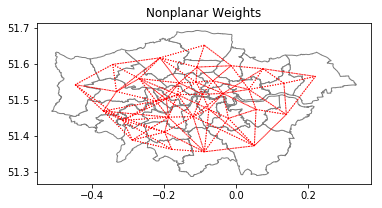

In [59]:
ax = gdf.plot(edgecolor='grey', facecolor='w')
f,ax = w_fuzzy_non.plot(gdf, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_title('Nonplanar Weights')

## <a id='Spatial Lag'>Spatial Lag<a/>
`Spatial lag` is the product of the spatial weights matrix and a given variable and that, if 𝑊 is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation.

In [60]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 17 columns):
borough               33 non-null object
sector                33 non-null object
population            33 non-null int64
households            33 non-null int64
dwellings             33 non-null int64
per_dwell             33 non-null float64
house_growth          32 non-null float64
house_stock           33 non-null int64
net_home              33 non-null int64
private_rent_price    33 non-null int64
house_price           33 non-null int64
earnings              32 non-null float64
ratio_price_earn      33 non-null int64
airbnb_amount         33 non-null int64
listing_price         33 non-null float64
reviews               33 non-null float64
geometry              33 non-null object
dtypes: float64(5), int64(9), object(3)
memory usage: 4.5+ KB


We will use variable for average airbnb listing price (`listing_price`) as an example to interpret the concept of `spatial lag`. Firstly let's have a general idea of the spatial distribution pattern.

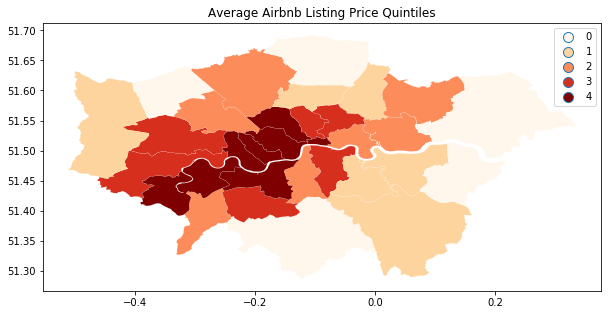

In [61]:
pr = ps.Quantiles(gdf.listing_price, k=5)
f, ax = plt.subplots(1, figsize=(10, 8))
gdf.assign(cl_pr=pr.yb).plot(column='cl_pr', categorical=True, k=5, cmap='OrRd', 
                                      linewidth=0.1, ax=ax, edgecolor='white', legend=True)

plt.title('Average Airbnb Listing Price Quintiles')
plt.show()

In [62]:
# get the spatial lag for listing price using queen weight
gdf['w_price'] = ps.lag_spatial(w_queen, gdf['listing_price'])
# list out the name, listing price, and spatial lag for City of London
gdf[['borough', 'listing_price', 'w_price']].loc[[32]]

,borough,listing_price,w_price
32,City of London,179.353571,105.817537


### <a id='Task 6'>Task 6<a/>
To interpret the spatial lag (w_price) result, we can take City of London as an example. The average pricing in City of London is about £105, it is surrounded by neighboring boroughs where the average listing price varies dramatically. We can further check its accuracy by querying the spatial weights matrix to find out the neighbors:

In [63]:
# get the queen spatial weight neighbors for City of London 
w_queen.neighbors[32]

[24, 25, 26, 27, 28]

In [64]:
# check the neighbors' price for private rent
nei_price = gdf.loc[w_queen.neighbors[32], 'listing_price']
nei_price

24    150.955773
25    121.052961
26     77.049487
27     94.839416
28     85.190049
Name: listing_price, dtype: float64

In [65]:
# get the average value for neighboring price
nei_price.mean()

105.81753738637526

For some of the techniques we will be seeing below, it makes more sense to operate with the standardized version of a variable, rather than with the raw one. Standardizing means to substract the average value and divide by the standard deviation each observation of the column. 

Can you work out the standardized value for airbnb listing price below; and further explore the spatial patterns of the standardized values, or $zscore$, we need to create its spatial lag:

In [66]:
# your code here
gdf['price_std'] = (gdf['listing_price'] - gdf['listing_price'].mean()) / gdf['listing_price'].std()
gdf['w_price_std'] = ps.lag_spatial(w_queen, gdf['price_std'])

## <a id='Spatial Autocorrelation'>Spatial Autocorrelation<a/>

Do you still remember `CSR`, the spatial randomness we had on Week 4? It justifies that a spatially random variable follows no discrenible distribution pattern over space, so the variable of interest in a given location will give no information about its value. In another word, if we take our **Airbnb listing price Quintiles** plot as an example, there should be no visible clustering of similar values on the map. However, we can easily spot out the gradient colors change from centre to inner then to outer London, which indicating that it is not CSR. 

On the contrary, **spatial autocorrelation** could be defined as "absence of spatial randomness" in that, for a given dataset, the $similarity$ $in$ $values$ among observations relates to their $locational$ $similarity$; hence relates the target observation's value with values in neighboring locations for specific variable. So in the following, we are trying to generate the meansures for spatial similarity and attribute similarity respectively, which had been utilized widely to generate combined measures for spatial autocorrelation. 

### <a id='Spatial Similarity'>Spatial Similarity<a/>
Spatial weights are used to measure spatial similarity as we've done in previous sections, here we will only use queen contiguity as an example:

In [67]:
W_queen = ps.queen_from_shapefile('data/borough_airbnb_housing.shp')
W_queen.transform = 'r' # row-standardize the contiguity weights

Spatial lag has been defined as derived variable pair the attribute similarity up with the spatial similarity.
For borough $i$ the spatial lag is defined as: ${price}$$Lag_i$=$∑_jw_{i,j}$${price_j}$, where $j$ are the neighboring boroughs for borough $i$.

In [68]:
price_Lag = ps.lag_spatial(W_queen, gdf['listing_price']) #spatial lag of the variable
price_LagQ5 = ps.Quantiles(price_Lag, k=5) # let's say k=5 for example

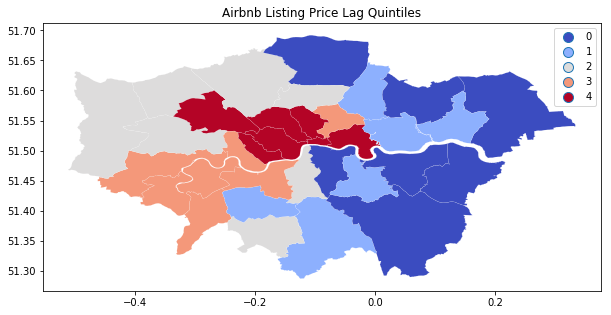

In [69]:
f, ax = plt.subplots(1, figsize=(10, 8))
gdf.assign(cl_lag=price_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Airbnb Listing Price Lag Quintiles')
plt.show()

Any differences? Is the quintiles map for spatial lag showing the enhancement of attribute similarity spatially? YES! However, if we want to give any statement on relationship between value of airbnb listing price in a borough and the value of spatial lag of the price for it, we still need one more step to justify it through statistical measures of spatial autocorrelation. We could use Moran Scatterplot for prelimenary visualization. 

### <a id='Moran Plot'>Moran Plot<a/>

Moran scatter plot is similar to normal scatter plot, but widely used to visualize spatial autocorrelation, with the variable of interest against x axis, whilst its spatial lag against y axis.

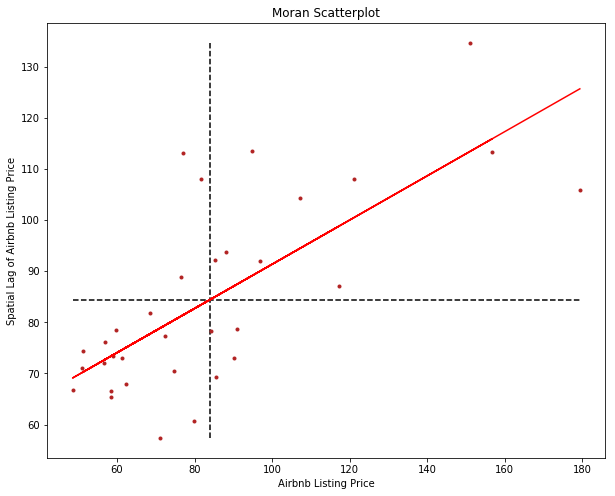

In [70]:
price=gdf.listing_price
b,a = np.polyfit(price, price_Lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(price, price_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's private rent level
plt.vlines(price.mean(), price_Lag.min(), price_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged private rent
plt.hlines(price_Lag.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Airbnb Listing Price')
plt.xlabel('Airbnb Listing Price')
plt.show()

We could also use `seaborn`'s regplot function to get the standardized value for variable(s) of interest plotted, as well as against its spatial lag. So now we will use the standardized values generated in Spatial Lag section for plotting:

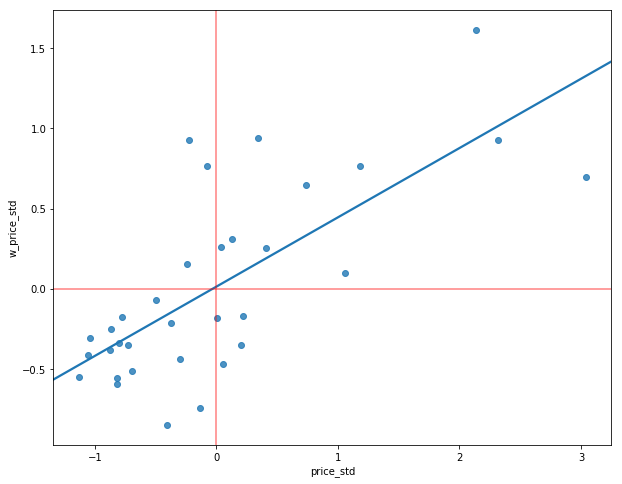

In [71]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(10, 8))
# Plot values
sns.regplot(x='price_std', y='w_price_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='r', alpha=0.5)
plt.axhline(0, c='r', alpha=0.5)
# Display
plt.show()

The figure above displays the relationship between the standardized airbnb listing price (`price_std`) and its spatial lag (`w_price_std`) in neighboring boroughs. The linear fit line is the best linear fit to the scatter plot representing the relationship between the two variables.

Be obvious from the plot that, these two variables have positive relationship, which leads to next section about two main types of spatial autocorrelations (SA): 
- **Positive spatial autocorrelation**: similar values tend to group together in similar locations. Generally, high values tend to be surrounded by high values, and low values to be close to low values, with justification of main pattern as clustered.
- **Negative spatial autocorrelation**: similar values tend to be dispersed and further apart from each other. Generally, high values tend to be surrounded by low values, and low values to be close to high values, with justification of main pattern as sparsed.

Meanwhile, we normally have two main classes of SA: (1) **Global spatial autocorrelation** and (2) **Local spatial autocorrelation**; and use Exploratory Spatial Data Analysis (`ESDA`) tools to realize the analysis purpose, i.e. spatial queries, statistical inference, choropleths, etc. 

### <a id='Global spatial autocorrelation'>Global spatial autocorrelation<a/>
Global spatial autocorrelation considers the overall geographical pattern of the target values presented, measure the trend statistically through statements about the degree of clustering, further summarize the result numerically for further visualization. This tool helps to answer questions concerning about geographical distribution patterns of values, the higher adjacency of similar values, etc. We will start interpreting the rationale of global spatial autocorrelation from binary view, and further practice with Moran's I statistic.

We can classify the "low listing price" and "high listing price" dividing by its median value to convert it into binary case.

In [72]:
gdf.listing_price.median()

77.04948738170347

In [73]:
binary = gdf.listing_price> gdf.listing_price.median()
sum(binary)

16

Among 33 boroughs, 16 of them with listing price above the median (£77) and 17 below the median.

In [74]:
binary = gdf.listing_price > gdf.listing_price.median()
labels = ['Low Price', 'High Price']
binary = [labels[i] for i in 1*binary] 
gdf['binary'] = binary

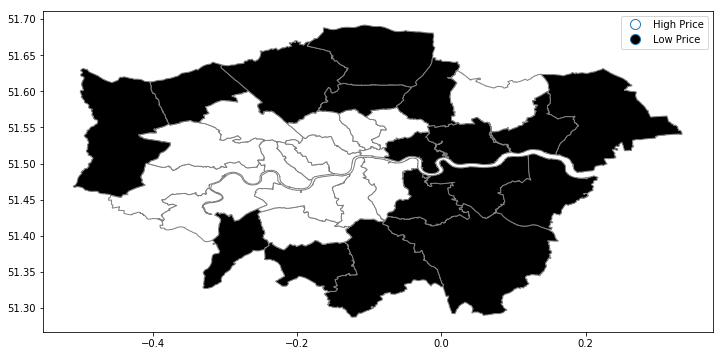

In [75]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
gdf.plot(column='binary', cmap='binary', edgecolor='grey', legend=True, ax=ax)

Has the plot recalled the image covered in lecture about calculating the joins in neighbors, especially counting the joins by three different types?
- BB (Black-Black)
- WW (White-White)
- BW (Black-White, or White-Black) 

The joins are reflected in our binary spatial weights object W_queen. So given 16 black polygons from this case, how many BB join should we expect for, if they were randomly assigned? We can work out the logic for join counts statistic as below:

In [76]:
from pysal import esda 
binary = 1 * (gdf.listing_price > gdf.listing_price.median()) # convert back to binary
W_queen = lps.weights.Queen.from_dataframe(gdf)
W_queen.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(binary, W_queen)

### <a id='Task 7'>Task 7<a/>
You may feel free to explore the number of bb, ww and bw by calling `jc.bb`, `jc.ww` and `jc.bw`.

In [77]:
# your code here
jc.bb

23.0

In [78]:
# your code here
jc.ww

19.0

In [79]:
# your code here
jc.bw

26.0

In [80]:
jc.bb + jc.ww + jc.bw

68.0

In [81]:
W_queen.s0 / 2

68.0

The result tells us that we have observed 23 BB joins in spatial weights objects. Is it departuring from the expected CSR (complete spatial randomness) hypothesis? We can test the statistical significance of our observations against the similated random spatial permutations (default at 999) under null of CSR in `PySAL`. Firstly check the mean value of expectation:

In [82]:
jc.mean_bb

15.625625625625625

How about the gap between observed count and the expectation? Should we reject the null of CSR hereby? Let's have a more intutive look:

Text(0.5, 0, 'BB Counts')

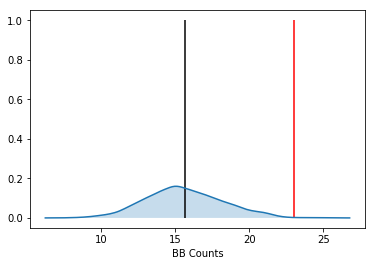

In [83]:
sns.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 1, color='r')
plt.vlines(jc.mean_bb, 0,1)
plt.xlabel('BB Counts')

With the black vertical line indicating mean BB count from the synthetic realizations, this density plot shows us the distribution of BB counts, whilst the red line is our observed count, which is extremely higher than the mean value. So let's further check the pseudo p-value for this statistic:

In [84]:
jc.p_sim_bb

0.005

So what will you conclude from the value? Write it down below:

** Since this is below conventional significance levels, we would reject the null of complete spatial randomness in favor of spatial autocorrelation in airbnb listing price in London. ** 

To summarize, we created the binary variable for airbnb listing price in London, and explore the join count analysis whilst disregarding information in the original values. So now let's turn back to our real data and test for the spatial autocorrelation.

In [85]:
mi = esda.moran.Moran(gdf.listing_price, W_queen) # call moran function
mi.I # print out the moran's I value

0.4322349014591009

### <a id='Task 8'>Task 8<a/>
Plot the statistic against a reference distribution under the null of CSR. 
    
**Hint**: similar to what we did in join count analysis. Call `seaborn`'s kdeplot function. But the expected value should be EI for $mi$.

Text(0.5, 0, "Moran's I")

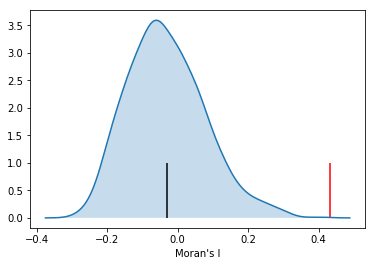

In [86]:
# your code here
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 4, color='r')
plt.vlines(mi.EI, 0, 4)
plt.xlabel("Moran's I")

In [87]:
# Check the statistical significance
mi.p_sim

0.001

This is just 0.1% (or you may get 0.002, 0.003..., slightly different everytime) and would be considered statistically significant. It means if we try to allocate the same values randomlly over space to get new map, then the Moran's $I$ statistic for new map could have 0.1% possibility to display a larger $I$ value than the one from our real data; while 99.9% of random mapping would receive a smaller $I$ value. As $I$ value could also be interpreted as the slope for Moran plot, the airbnb listing price in London is more concentrated than if it follows a CSR process, hence statistically significance, and has its spatial structure. 

Besides of calling `esda` in PySAL, we can also realize the Moran's I statistic by directly calling the specific function in `PySAL.Moran`. 

In [88]:
I_price = ps.Moran(gdf.listing_price.values, W_queen)  # Moran's I
I_price.I, I_price.p_sim  #value of statistic, inference on Moran's I

(0.4322349014591009, 0.003)

Thus, the $I$ statistic is $0.4322$ for this data, and has a very small $p$ value.

In [89]:
b # I is same as the slope of the line in the scatterplot

0.4322349014591008

In [90]:
I_price.sim[0:5]

array([ 0.15758369, -0.16431379, -0.05480384, -0.16579208, -0.22383664])

Let us visualize the distribution using KDEplot again, with a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic.

(-0.4, 0.6)

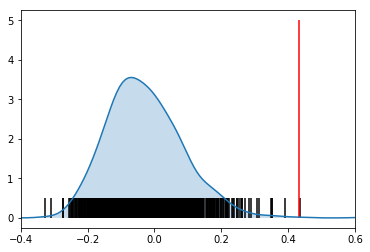

In [91]:
sns.kdeplot(I_price.sim, shade=True)
plt.vlines(I_price.sim, 0, 0.5)
plt.vlines(I_price.I, 0, 5, 'r')
plt.xlim([-0.4, 0.6])

if our $I$ statistic were close to our expected value, I_price.EI , our plot might look like this:

(-0.4, 0.6)

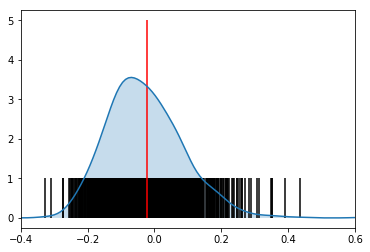

In [92]:
sns.kdeplot(I_price.sim, shade=True)
plt.vlines(I_price.sim, 0, 1)
plt.vlines(I_price.EI+.01, 0, 5, 'r')
plt.xlim([-0.4, 0.6])

We can arrive at the conclusion now: the pattern for airbnb listing price is not spatially random, but instead has signficant spatial association.

### <a id='Local spatial autocorrelation'>Local spatial autocorrelation<a/>
Instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`.

In [93]:
lisa = ps.Moran_Local(gdf['listing_price'].values, w_queen, permutations=999)
lisa.Is

array([-3.75299503e-02,  3.34425205e-01,  3.56154276e-01,  3.99597464e-02,
       -3.74999856e-02,  4.85613008e-01,  1.35644204e-01,  2.20381783e-01,
       -6.08535947e-02,  8.03851695e-02, -7.09969348e-04, -2.38077145e-02,
        2.55549823e-01,  3.49288375e-01,  6.23986775e-01,  4.53674040e-01,
        2.73920840e-01,  1.00962139e-01,  3.18375985e-01,  1.04045646e-01,
       -6.93937073e-02,  1.03790033e-01,  4.75811669e-01,  2.15732182e+00,
        3.44832688e+00,  9.00209884e-01, -2.06753249e-01,  3.24311448e-01,
        9.59404843e-03,  3.53374991e-02,  1.29318041e-01,  4.38773111e-01,
        2.11290356e+00])

In [94]:
lisa.q   # quantile classification

array([2, 3, 3, 1, 4, 3, 3, 3, 2, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 1, 4, 1,
       1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1])

In [95]:
lisa.p_sim

array([0.369, 0.206, 0.056, 0.236, 0.378, 0.154, 0.419, 0.292, 0.016,
       0.34 , 0.395, 0.225, 0.263, 0.02 , 0.176, 0.115, 0.199, 0.026,
       0.271, 0.348, 0.221, 0.303, 0.083, 0.052, 0.003, 0.022, 0.078,
       0.041, 0.228, 0.454, 0.14 , 0.204, 0.02 ])

In [96]:
(lisa.p_sim < 0.05).sum()

7

A Moran scatterplot with statistically significant LISA values highlighted. We want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way.

In [97]:
gdf['lag_price'] = ps.lag_spatial(w_queen, gdf['listing_price'])
sigs = gdf['listing_price'][lisa.p_sim <= .05]
W_sigs = gdf['lag_price'][lisa.p_sim <= .05]
insigs = gdf['listing_price'][lisa.p_sim > .05]
W_insigs = gdf['lag_price'][lisa.p_sim > .05]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the alpha keyword. In addition, we would like to plot the statistically significant points in a dark red color with triangle shape.

Text(0.5, 0, 'Airbnb Listing Price')

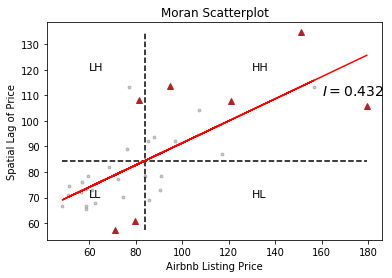

In [98]:
b,a = np.polyfit(gdf['listing_price'], gdf['lag_price'], 1)
moran=ps.Moran(gdf['listing_price'].values, w_queen)

plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(gdf['listing_price'].mean(), gdf['lag_price'].min(), gdf['lag_price'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(gdf['lag_price'].mean(), gdf['listing_price'].min(), gdf['listing_price'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(gdf['listing_price'], a + b*gdf['listing_price'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=160, y=110, fontsize=14)
plt.text(130, 120, "HH", fontsize=11)
plt.text(130, 70, "HL", fontsize=11)
plt.text(60, 120, "LH", fontsize=11)
plt.text(60, 70, "LL", fontsize=11)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Airbnb Listing Price')

We can again test for local clustering using permutations, but here we use conditional random permutations (different distributions for each focal location).

In [99]:
lisa_new = ps.Moran_Local(gdf['listing_price'].values, w_queen, permutations=9999)
lisa_new.q

array([2, 3, 3, 1, 4, 3, 3, 3, 2, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 1, 4, 1,
       1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1])

Any spotted differences? Could you check the other features for lisa_new then?

After measuring both global and local spatial autocorrelation, let's visualize the results on London map.

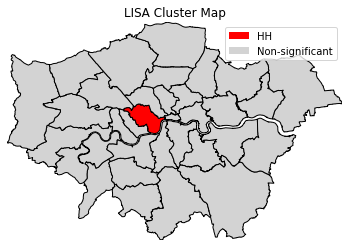

In [100]:
data='data/borough_airbnb_housing.shp'
viz.plot_lisa_cluster(data,lisa, title="LISA Cluster Map")

So far, only high value surrounded by high values has been highlighted. However, we can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot as:

In [101]:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3
doughnut = sig * lisa.q==2
diamond = sig * lisa.q==4

In [102]:
hotspot.sum()

4

In [103]:
# list the boroughs which are hotspots
gdf['listing_price'][hotspot]

24    150.955773
25    121.052961
27     94.839416
32    179.353571
Name: listing_price, dtype: float64

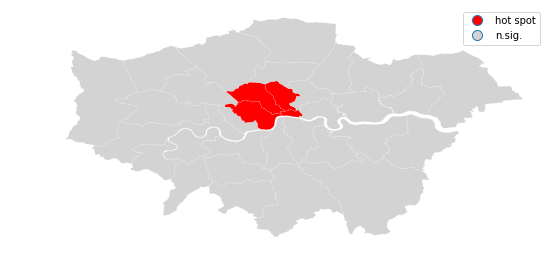

In [104]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

### <a id='Task 9'>Task 9<a/>
    
Get the information for coldspot, doughnut and diamond by yourself.

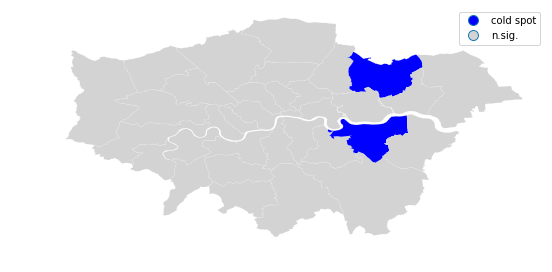

In [105]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

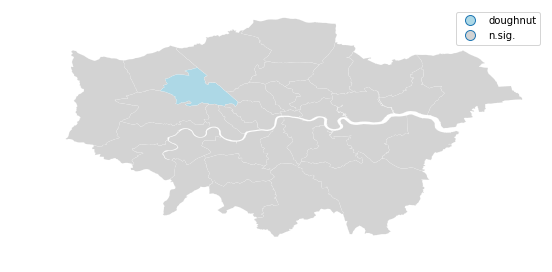

In [106]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]
 
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

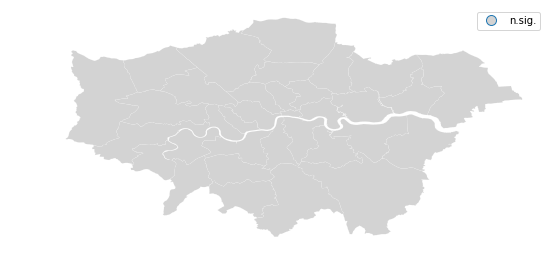

In [107]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

from matplotlib import colors
hmap = colors.ListedColormap(['lightgrey', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

What do you have for diamond? Actually, if you go back to our Moran's I plot for significant points, you may find there is no significant point falling in this category. 

With LISAs in `PySAL`, we classify the observations into 4 groups by its value and the neighbors', exploring their concentration pattern, identifying cases either more similar (**HH, LL**) concentrated or dissimilar (**HL, LH**) around.  The mechanism is similar to Moran's $I$, but applied in this case to each observation. This tool is widely used in identifying clusters in space, and provide suggestive evidence about the processes that might be at work, e.g.identification of spatial clusters of groups of people, delineation of areas with particularly high/low frequency of certain activity, etc.

### <a id='Task 10'>Task 10<a/>
Now let us pull out areas with statistically significant spatial clustering (at the 5% level):

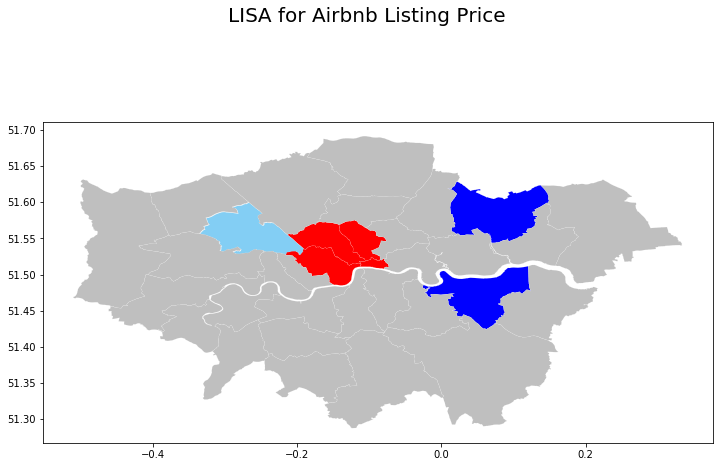

In [108]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(12, 8))
# Plot building blocks
gdf.plot(ax=ax, facecolor='1', linewidth=0.1)
# Plot HH clusters
hh = gdf.loc[(lisa.q==1) & ((lisa.p_sim<0.05)==True), 'geometry']
hh.plot(ax=ax, color='red', linewidth=0.1, edgecolor='w')

# Plot LL clusters
ll = gdf.loc[(lisa.q==3) & ((lisa.p_sim<0.05)==True), 'geometry']
ll.plot(ax=ax, color='blue', linewidth=0.1, edgecolor='w')
# Plot LH clusters
lh = gdf.loc[(lisa.q==2) & ((lisa.p_sim<0.05)==True), 'geometry']
lh.plot(ax=ax, color='#83cef4', linewidth=0.1, edgecolor='w')
# Plot HL clusters
hl = gdf.loc[(lisa.q==4) & ((lisa.p_sim<0.05)==True), 'geometry']
hl.plot(ax=ax, color='#e59696', linewidth=0.1, edgecolor='w')
# Non-significant
ns = gdf.loc[(lisa.p_sim<0.05)!=True, 'geometry']
ns.plot(ax=ax, color='0.75', linewidth=0.1, edgecolor='w')
# Style and draw
f.suptitle('LISA for Airbnb Listing Price', size=20)
f.set_facecolor('w')
plt.show()

# Credits!